In [68]:
library('RODBC')
library('quantmod')
library('PerformanceAnalytics')
library('forecast')
library('lubridate')
source("/usr/common/config.R")
lcon <- odbcDriverConnect(sprintf("Driver={SQL Server};Server=%s;Database=%s;Uid=%s;Pwd=%s;", ldbserver, ldbname, ldbuser, ldbpassword), case = "nochange", believeNRows = TRUE)

In [69]:
lookbacks<-c(100, 200, 500, 1000)
startDate<-as.Date("1997-01-01")
indexName<-'NIFTY 50'

prices<-sqlQuery(lcon, sprintf("select TIME_STAMP, PX_CLOSE from BHAV_INDEX
                                    where TIME_STAMP >='%s'
                                    and INDEX_NAME='%s'", startDate, indexName))

pXts<-xts(prices[,2], as.Date(prices[,1]))
retXts<-dailyReturn(pXts)

Warning message:
“closing unused RODBC handle 4”

In [70]:
dpredXts<-retXts
for(i in 1:length(lookbacks)){
    lb<-as.numeric(lookbacks[i])

    pRet<-rollapply(retXts, lb, FUN=function(x){
        fcast<-NA
        tryCatch({
            m111<-Arima(x, order=c(1,1,1))
            fcast<-forecast(m111, 1)[[4]][1]
        },
        error=function(x){})
        fcast
    }, by.column=F)

    dpredXts<-merge(dpredXts, pRet)
}

names(dpredXts)<-c('N', lookbacks)
dpredXts[,1]<-lag(dpredXts[,1], -1)

In [71]:
dpredXts[,2]<-na.locf(dpredXts[,2])
dpredXts[,3]<-na.locf(dpredXts[,3])
dpredXts[,4]<-na.locf(dpredXts[,4])
dpredXts[,5]<-na.locf(dpredXts[,5])
dpredXts<-na.omit(dpredXts)

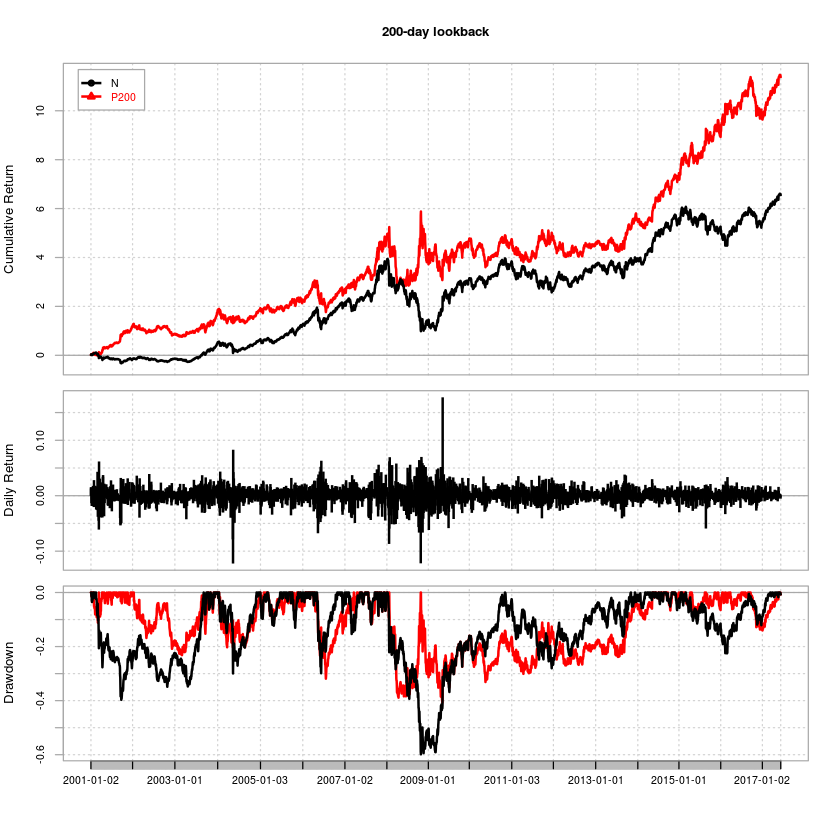

In [72]:
dpredXts$P100<-ifelse(dpredXts[,2] > 0, dpredXts[,1], -dpredXts[,1])
dpredXts$P200<-ifelse(dpredXts[,3] > 0, dpredXts[,1], -dpredXts[,1])
dpredXts$P500<-ifelse(dpredXts[,4] > 0, dpredXts[,1], -dpredXts[,1])
dpredXts$P1000<-ifelse(dpredXts[,5] > 0, dpredXts[,1], -dpredXts[,1])

#charts.PerformanceSummary(na.omit(merge(dpredXts[,1], dpredXts$P100)), main="100-day lookback")
charts.PerformanceSummary(na.omit(merge(dpredXts[,1], dpredXts$P200)), main="200-day lookback")
#charts.PerformanceSummary(na.omit(merge(dpredXts[,1], dpredXts$P500)), main="500-day lookback")
#charts.PerformanceSummary(na.omit(merge(dpredXts[,1], dpredXts$P1000)), main="1000-day lookback")

In [73]:
print(sprintf("Buy&Hold: Cumulative = %.2f%%; Annualized = %.2f%%", 100*Return.cumulative(dpredXts[,1]), 100*Return.annualized(dpredXts[,1])))

for(i in 1:length(lookbacks)){
    ii<-sprintf("P%d", lookbacks[i])
    print(sprintf("LB: %d; Long/Short: Cumulative = %.2f%%; Annualized = %.2f%%", lookbacks[i], 100*Return.cumulative(dpredXts[,ii]), 100*Return.annualized(dpredXts[,ii])))
}

[1] "Buy&Hold: Cumulative = 655.38%; Annualized = 13.25%"
[1] "LB: 100; Long/Short: Cumulative = 467.33%; Annualized = 11.28%"
[1] "LB: 200; Long/Short: Cumulative = 1137.98%; Annualized = 16.75%"
[1] "LB: 500; Long/Short: Cumulative = 1257.05%; Annualized = 17.41%"
[1] "LB: 1000; Long/Short: Cumulative = 774.04%; Annualized = 14.28%"


In [74]:
allYears<-unique(year(index(dpredXts[,1])))

for(y in allYears){
    yStr<-toString(y)
    print(sprintf("Year: %s, Buy&Hold: %.2f%%", y, 100*Return.cumulative(dpredXts[yStr,1])))
    for(i in 1:length(lookbacks)){
        ii<-sprintf("P%d", lookbacks[i])
        print(sprintf("LB: %d; Long/Short: %.2f%%", lookbacks[i], 100*Return.cumulative(dpredXts[yStr,ii])))
    }
    
    print("-------------------------------------")
}

[1] "Year: 2001, Buy&Hold: -17.02%"
[1] "LB: 100; Long/Short: 58.65%"
[1] "LB: 200; Long/Short: 118.21%"
[1] "LB: 500; Long/Short: 99.68%"
[1] "LB: 1000; Long/Short: 62.63%"
[1] "-------------------------------------"
[1] "Year: 2002, Buy&Hold: 4.25%"
[1] "LB: 100; Long/Short: 0.35%"
[1] "LB: 200; Long/Short: -13.80%"
[1] "LB: 500; Long/Short: 18.33%"
[1] "LB: 1000; Long/Short: -1.36%"
[1] "-------------------------------------"
[1] "Year: 2003, Buy&Hold: 73.82%"
[1] "LB: 100; Long/Short: 78.48%"
[1] "LB: 200; Long/Short: 48.73%"
[1] "LB: 500; Long/Short: 70.79%"
[1] "LB: 1000; Long/Short: 82.08%"
[1] "-------------------------------------"
[1] "Year: 2004, Buy&Hold: 10.60%"
[1] "LB: 100; Long/Short: -14.68%"
[1] "LB: 200; Long/Short: 4.67%"
[1] "LB: 500; Long/Short: 18.08%"
[1] "LB: 1000; Long/Short: 13.25%"
[1] "-------------------------------------"
[1] "Year: 2005, Buy&Hold: 34.09%"
[1] "LB: 100; Long/Short: 8.10%"
[1] "LB: 200; Long/Short: 8.51%"
[1] "LB: 500; Long/Short: 32.20%"


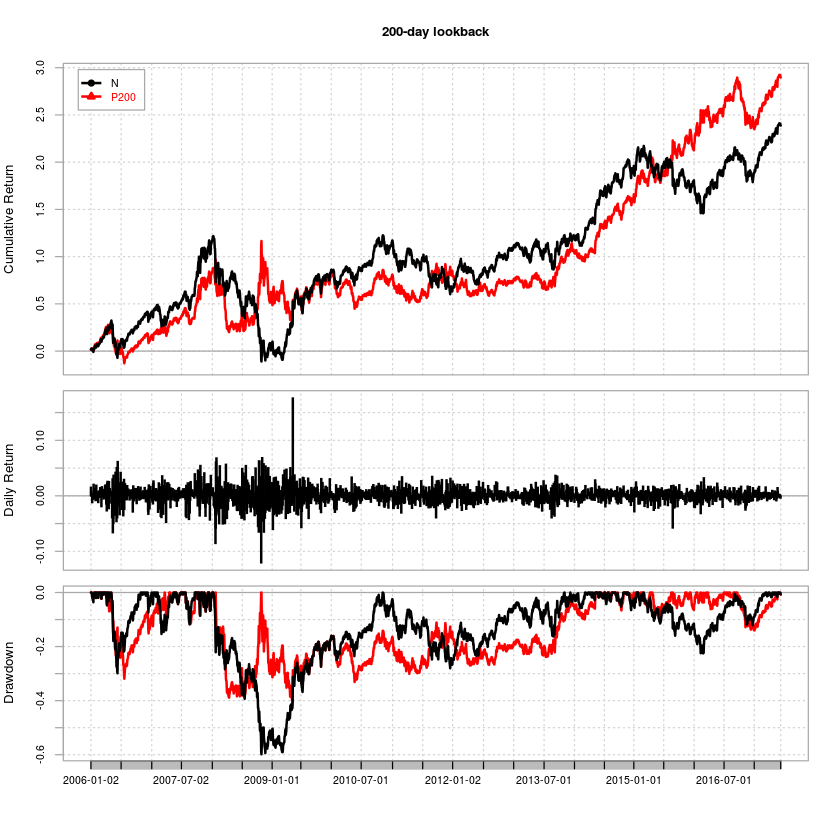

In [75]:
charts.PerformanceSummary(na.omit(merge(dpredXts["2006/",1], dpredXts["2006/", 'P200'])), main="200-day lookback")